# Video Classification Testing

This notebook restores the video network trained for grasp testset1 stored in `grasp_120x90_testset1_logs` and test it.

## Dependencies

`Python 3.5.4` is used for development and following packages are required to run the code provided in the notebook:

`pip install googledrivedownloader`<br>
`pip install matplotlib`<br>
`pip install tensorflow-gpu`<br>
`pip install keras`<br>
`pip install numpy`

In [1]:
import pickle, os, csv, time, shutil
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from google_drive_downloader import GoogleDriveDownloader as gdd

In [2]:
def print_image(image, title):
    """Print the image

    :param image: image pixels in list
    :param title: title as string to be printed on top of the image
    """
    plt.imshow(image)
    plt.title(title)
    plt.colorbar()
    plt.show()

def time_taken(start, end):
    """Human readable time between `start` and `end`

    :param start: time.time()
    :param end: time.time()
    :returns: day:hour:minute:second
    """
    time = end-start
    day = time // (24 * 3600)
    time = time % (24 * 3600)
    hour = time // 3600
    time %= 3600
    minutes = time // 60
    time %= 60
    seconds = time
    day_hour_min_sec = str('%02d' % int(day))+":"+str('%02d' % int(hour))+":"+str('%02d' % int(minutes))+":"+str('%02d' % int(seconds))
    
    return day_hour_min_sec

In [3]:
"""
Downloading `category_object_labels.bin`.
This contains two dictionaries that stores category labels and object labels
"""

gdd.download_file_from_google_drive(file_id='15xPAbso4-uLk8PcRi9cb70r1r3FaU6ux',
                                    dest_path='./dataset/category_object_labels.bin',
                                    unzip=False)

bin_file = open("./dataset/category_object_labels.bin", "rb")

category_labels = pickle.load(bin_file)
object_labels = pickle.load(bin_file)

bin_file.close()

## Video Dataset

In [4]:
"""
Downloading testset1 for video of grasp interaction and reading it.
"""

db_file_name = "grasp_120x90_testset1.bin"
gdd.download_file_from_google_drive(file_id='1o8FvoQskCS9rE8Bh4VkUUNMtJgKmDe67',
                                    dest_path='./dataset/'+db_file_name,
                                    unzip=False)

bin_file = open("./dataset/"+db_file_name, "rb")

video_frames_5d_train = pickle.load(bin_file)
category_label_train = pickle.load(bin_file)
object_label_train = pickle.load(bin_file)
category_label_train_one_hot = pickle.load(bin_file)
object_label_train_one_hot = pickle.load(bin_file)

video_frames_5d_test = pickle.load(bin_file)
category_label_test = pickle.load(bin_file)
object_label_test = pickle.load(bin_file)
category_label_test_one_hot = pickle.load(bin_file)
object_label_test_one_hot = pickle.load(bin_file)

bin_file.close()

batch, frames, height, width, channel:  (400, 20, 90, 120, 3)


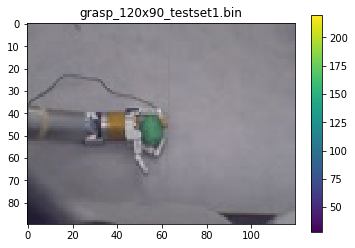

Category:  egg
Object:  egg_rough_styrofoam


In [5]:
"""
Display a frame of the video dataset
"""

batch_no = 188
frame_no = 10

print("batch, frames, height, width, channel: ", video_frames_5d_train.shape)

print_image(video_frames_5d_train[batch_no][frame_no], db_file_name)

print("Category: ", list(category_labels.keys())[list(category_labels.values()).index(category_label_train[batch_no])])
print("Object: ", list(object_labels.keys())[list(object_labels.values()).index(object_label_train[batch_no])])

## Building the Video Network Architecture

<img src="pics/Video_TT_GRU.png" alt="drawing" width="600px"/>

## Video Network Hyper-parameters

The input dimension at each time step is 120 x 90 x 3 = 32,400 which is factorized as 2 x 90 x 90 x 2, the hidden layer is chosen to be 6 x 6 x 6 x 6 = 1,296 and the Tensor-Train ranks are [1, 4, 4, 4, 1].
A fully-connected layer for such a mapping would have required 41,990,400 (32,400 x 1,296) parameters to learn, however the input-to-hidden layer in TT-GRU required only 17,472 parameters.

We applied 0.25 Dropout for both input-to-hidden and hidden-to-hidden mappings in plain GRU as well as its TT modifications; and 0.01 ridge regularization for the single-layered classifier.
The model was deployed in Keras and TensorFlow was used as backend.
We trained for 150 epochs and used the Adam, an gradient-based stochastic optimization algorithm with a learning rate of 1 x $10^{-4}$.

In [6]:
# Hyper-parameters
batch = 1
training_epochs = 150
display_step = 1

frames = time_step_size = video_frames_5d_train.shape[1]
height = video_frames_5d_train.shape[2]
width = video_frames_5d_train.shape[3]
channel = video_frames_5d_train.shape[4]
num_classes = category_label_train_one_not.shape[1]

model_path = db_file_name.split(".")[0]+"_logs/model.ckpt"
logs_path = db_file_name.split(".")[0]+"_logs/"

X = tf.placeholder('float', [None, None, height, width, channel], name='InputData')
Y = tf.placeholder('float', [None, num_classes], name='LabelData')

In [7]:
gdd.download_file_from_google_drive(file_id='1NPs3CMhbZ-C6CpbEWX4kJAkhzHe-gNbG',
                                    dest_path='./TTRNN.py',
                                    unzip=False)

In [8]:
from TTRNN import TT_GRU, TT_LSTM
from keras.regularizers import l2
from keras.layers import Dense

tt_input_shape = [2, 90, 90, 2]
tt_output_shape = [6, 6, 6, 6]
tt_ranks = [1, 4, 4, 4, 1]
alpha = 1e-2

"""
Functions used to define the Neural Network
"""

def model(data_placeholder):
    with tf.name_scope("Model"):
        XR = tf.reshape(data_placeholder, [batch, frames, height*width*channel])
        rnn_layer = TT_GRU(tt_input_shape=tt_input_shape, tt_output_shape=tt_output_shape,
                               tt_ranks=tt_ranks,
                                return_sequences=False,
                                dropout=0.25, recurrent_dropout=0.25, activation='tanh')
        h = rnn_layer(XR)
        logits = Dense(output_dim=num_classes, activation='softmax', kernel_regularizer=l2(alpha))(h)
    return logits

def loss(prediction, label_placeholder):
    with tf.name_scope('Loss'):
        cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=prediction, labels=label_placeholder))
        # Create a summary to monitor cost tensor
        cost_scalar = tf.summary.scalar("loss", cost)
    return cost, cost_scalar

def training(prediction, label_placeholder):
    with tf.name_scope('Optimizer'):
        optimizer = tf.train.AdamOptimizer(learning_rate=0.0001)
        train_op = optimizer.minimize(cost)
    return train_op

def evaluate(prediction, Y):
    with tf.name_scope('Accuracy'):
        # Test model
        correct_prediction = tf.equal(tf.argmax(prediction, 1), tf.argmax(Y, 1))
        # Calculate accuracy
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float'))
        # Create a summary to monitor accuracy tensor
        accuracy_scalar = tf.summary.scalar("accuracy", accuracy)
    return accuracy, accuracy_scalar

Using TensorFlow backend.


In [9]:
"""
Creating the Neural Network
"""

model_dict = {}

prediction = model(X)
model_dict["Model"] = prediction

cost, cost_scalar = loss(prediction, Y)
model_dict["Loss"] = cost
model_dict["Loss_scalar"] = cost_scalar

train_op = training(prediction, Y)
model_dict["Optimizer"] = train_op

eval_op, accuracy_scalar = evaluate(prediction, Y)
model_dict["Accuracy"] = eval_op
model_dict["Accuracy_scalar"] = accuracy_scalar

print("model_dict: ", model_dict)

# Initializing the variables
init = tf.global_variables_initializer()

# 'Saver' op to save and restore all the variables
saver = tf.train.Saver(max_to_keep=1)

Compression factor = 17472 / 125971200 = 0.00013869836915104405
Compressrion factor = 0.00013869836915104405


c:\anaconda2\envs\py3\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", kernel_regularizer=<keras.reg..., units=20)`


model_dict:  {'Model': <tf.Tensor 'Model/dense_1/Softmax:0' shape=(1, 20) dtype=float32>, 'Loss': <tf.Tensor 'Loss/Mean:0' shape=() dtype=float32>, 'Loss_scalar': <tf.Tensor 'Loss/loss:0' shape=() dtype=string>, 'Optimizer': <tf.Operation 'Optimizer/Adam' type=NoOp>, 'Accuracy': <tf.Tensor 'Accuracy/Mean:0' shape=() dtype=float32>, 'Accuracy_scalar': <tf.Tensor 'Accuracy/accuracy:0' shape=() dtype=string>}


## Testing for the whole video

In [10]:
# Evaluate on test set

with tf.Session() as sess:
    sess.run(init)
    saver.restore(sess, tf.train.latest_checkpoint(logs_path))
    
    avg_accuracy_list = 0.0
    total_batch = int(len(video_frames_5d_test)/batch)
    
    for start, end in zip(range(0, len(video_frames_5d_test), batch), range(batch, len(video_frames_5d_test)+1, batch)):
        input_data, label_data = video_frames_5d_test[start:end], category_label_test_one_not[start:end]
        accuracy = sess.run(model_dict["Accuracy"], feed_dict={X: input_data, Y: label_data})
        avg_accuracy_list += accuracy/total_batch
    
    print("Overall Accuracy: ", avg_accuracy_list)

INFO:tensorflow:Restoring parameters from grasp_120x90_testset1_logs/model.ckpt-149
Overall Accuracy:  0.7100000000000004


## Testing for each frame in the video

In [11]:
# Predict after every frame of a video

all_frames_acc = {}
for a_frame in range(1, frames+1):
    all_frames_acc[a_frame] = [0, 0, 0] # correct, wrong, percentage

y_pred = {}
y_score = {}
for a_frame in range(1, frames+1):
    y_pred[a_frame] = []
    y_score[a_frame] = []
    
def fill_example(example, fill_frames, a_frame):
    temp = []
    temp.append(example[a_frame-1])
    for _ in range(fill_frames):
        example = np.concatenate((example, temp))
    return example

def give_me_complete_clip(num_of_frame, example):
    fill_frames = frames - num_of_frame
    if fill_frames != 0:
        example = fill_example(example, fill_frames, num_of_frame)
    return example

with tf.Session() as sess:
    sess.run(init)
    saver.restore(sess, tf.train.latest_checkpoint(logs_path))
    
    for i_example in range(len(video_frames_5d_test)):
        print("Example Number: ", i_example+1)
        input_data, label_data = video_frames_5d_test[i_example], category_label_test_one_not[i_example]
        
        truth = np.argmax(label_data, 0)+1
        truth_cate = list(category_labels.keys())[list(category_labels.values()).index(truth)]
        print("True Category: ", truth_cate)
        
        for a_frame in range(1, frames+1):
            
            example = give_me_complete_clip(a_frame, input_data[0:a_frame])
            
            temp = []
            temp.append(example)
            
            predic = sess.run(model_dict["Model"], feed_dict={X: temp})
            argmax = sess.run(tf.argmax(predic, 1))+1
            cate = list(category_labels.keys())[list(category_labels.values()).index(argmax)]
            print("Frame No.: ", a_frame, "Prediction: ", cate)
            
            y_pred[a_frame].extend(argmax)
            y_score[a_frame].extend(predic)
            
            if truth_cate == cate:
                all_frames_acc[a_frame][0] += 1
            else:
                all_frames_acc[a_frame][1] += 1
            all_frames_acc[a_frame][2] = all_frames_acc[a_frame][0]/(all_frames_acc[a_frame][0]+all_frames_acc[a_frame][1])
            
        print("X"*50)

INFO:tensorflow:Restoring parameters from grasp_120x90_testset1_logs/model.ckpt-149
Example Number:  1
True Category:  ball
Frame No.:  1 Prediction:  ball
Frame No.:  2 Prediction:  ball
Frame No.:  3 Prediction:  ball
Frame No.:  4 Prediction:  ball
Frame No.:  5 Prediction:  ball
Frame No.:  6 Prediction:  ball
Frame No.:  7 Prediction:  ball
Frame No.:  8 Prediction:  ball
Frame No.:  9 Prediction:  ball
Frame No.:  10 Prediction:  ball
Frame No.:  11 Prediction:  ball
Frame No.:  12 Prediction:  ball
Frame No.:  13 Prediction:  ball
Frame No.:  14 Prediction:  ball
Frame No.:  15 Prediction:  ball
Frame No.:  16 Prediction:  ball
Frame No.:  17 Prediction:  ball
Frame No.:  18 Prediction:  ball
Frame No.:  19 Prediction:  ball
Frame No.:  20 Prediction:  ball
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Example Number:  2
True Category:  ball
Frame No.:  1 Prediction:  ball
Frame No.:  2 Prediction:  ball
Frame No.:  3 Prediction:  ball
Frame No.:  4 Prediction:  ball
Frame 

Frame No.:  12 Prediction:  bigstuffedanimal
Frame No.:  13 Prediction:  bigstuffedanimal
Frame No.:  14 Prediction:  bigstuffedanimal
Frame No.:  15 Prediction:  bigstuffedanimal
Frame No.:  16 Prediction:  bigstuffedanimal
Frame No.:  17 Prediction:  bigstuffedanimal
Frame No.:  18 Prediction:  bigstuffedanimal
Frame No.:  19 Prediction:  bigstuffedanimal
Frame No.:  20 Prediction:  bigstuffedanimal
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Example Number:  12
True Category:  bigstuffedanimal
Frame No.:  1 Prediction:  bigstuffedanimal
Frame No.:  2 Prediction:  bigstuffedanimal
Frame No.:  3 Prediction:  bigstuffedanimal
Frame No.:  4 Prediction:  bigstuffedanimal
Frame No.:  5 Prediction:  bigstuffedanimal
Frame No.:  6 Prediction:  bigstuffedanimal
Frame No.:  7 Prediction:  bigstuffedanimal
Frame No.:  8 Prediction:  bigstuffedanimal
Frame No.:  9 Prediction:  bigstuffedanimal
Frame No.:  10 Prediction:  bigstuffedanimal
Frame No.:  11 Prediction:  bigstuffedanimal
Frame

Frame No.:  8 Prediction:  can
Frame No.:  9 Prediction:  can
Frame No.:  10 Prediction:  can
Frame No.:  11 Prediction:  can
Frame No.:  12 Prediction:  can
Frame No.:  13 Prediction:  can
Frame No.:  14 Prediction:  can
Frame No.:  15 Prediction:  can
Frame No.:  16 Prediction:  can
Frame No.:  17 Prediction:  can
Frame No.:  18 Prediction:  can
Frame No.:  19 Prediction:  can
Frame No.:  20 Prediction:  can
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Example Number:  22
True Category:  can
Frame No.:  1 Prediction:  can
Frame No.:  2 Prediction:  can
Frame No.:  3 Prediction:  can
Frame No.:  4 Prediction:  can
Frame No.:  5 Prediction:  can
Frame No.:  6 Prediction:  can
Frame No.:  7 Prediction:  can
Frame No.:  8 Prediction:  can
Frame No.:  9 Prediction:  can
Frame No.:  10 Prediction:  can
Frame No.:  11 Prediction:  can
Frame No.:  12 Prediction:  can
Frame No.:  13 Prediction:  can
Frame No.:  14 Prediction:  can
Frame No.:  15 Prediction:  can
Frame No.:  16 Predictio

Frame No.:  14 Prediction:  ball
Frame No.:  15 Prediction:  ball
Frame No.:  16 Prediction:  ball
Frame No.:  17 Prediction:  ball
Frame No.:  18 Prediction:  ball
Frame No.:  19 Prediction:  ball
Frame No.:  20 Prediction:  ball
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Example Number:  43
True Category:  eggcoloringcup
Frame No.:  1 Prediction:  ball
Frame No.:  2 Prediction:  ball
Frame No.:  3 Prediction:  ball
Frame No.:  4 Prediction:  ball
Frame No.:  5 Prediction:  ball
Frame No.:  6 Prediction:  ball
Frame No.:  7 Prediction:  ball
Frame No.:  8 Prediction:  ball
Frame No.:  9 Prediction:  ball
Frame No.:  10 Prediction:  ball
Frame No.:  11 Prediction:  ball
Frame No.:  12 Prediction:  ball
Frame No.:  13 Prediction:  ball
Frame No.:  14 Prediction:  ball
Frame No.:  15 Prediction:  ball
Frame No.:  16 Prediction:  ball
Frame No.:  17 Prediction:  ball
Frame No.:  18 Prediction:  ball
Frame No.:  19 Prediction:  ball
Frame No.:  20 Prediction:  ball
XXXXXXXXXXXXXXXX

Frame No.:  11 Prediction:  medicine
Frame No.:  12 Prediction:  medicine
Frame No.:  13 Prediction:  medicine
Frame No.:  14 Prediction:  medicine
Frame No.:  15 Prediction:  medicine
Frame No.:  16 Prediction:  medicine
Frame No.:  17 Prediction:  medicine
Frame No.:  18 Prediction:  medicine
Frame No.:  19 Prediction:  medicine
Frame No.:  20 Prediction:  medicine
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Example Number:  54
True Category:  medicine
Frame No.:  1 Prediction:  medicine
Frame No.:  2 Prediction:  medicine
Frame No.:  3 Prediction:  medicine
Frame No.:  4 Prediction:  medicine
Frame No.:  5 Prediction:  medicine
Frame No.:  6 Prediction:  medicine
Frame No.:  7 Prediction:  medicine
Frame No.:  8 Prediction:  medicine
Frame No.:  9 Prediction:  medicine
Frame No.:  10 Prediction:  medicine
Frame No.:  11 Prediction:  medicine
Frame No.:  12 Prediction:  medicine
Frame No.:  13 Prediction:  medicine
Frame No.:  14 Prediction:  medicine
Frame No.:  15 Prediction

Frame No.:  17 Prediction:  noodle
Frame No.:  18 Prediction:  noodle
Frame No.:  19 Prediction:  noodle
Frame No.:  20 Prediction:  noodle
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Example Number:  64
True Category:  noodle
Frame No.:  1 Prediction:  ball
Frame No.:  2 Prediction:  eggcoloringcup
Frame No.:  3 Prediction:  ball
Frame No.:  4 Prediction:  ball
Frame No.:  5 Prediction:  ball
Frame No.:  6 Prediction:  ball
Frame No.:  7 Prediction:  ball
Frame No.:  8 Prediction:  ball
Frame No.:  9 Prediction:  ball
Frame No.:  10 Prediction:  ball
Frame No.:  11 Prediction:  ball
Frame No.:  12 Prediction:  ball
Frame No.:  13 Prediction:  ball
Frame No.:  14 Prediction:  ball
Frame No.:  15 Prediction:  ball
Frame No.:  16 Prediction:  ball
Frame No.:  17 Prediction:  ball
Frame No.:  18 Prediction:  ball
Frame No.:  19 Prediction:  ball
Frame No.:  20 Prediction:  ball
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Example Number:  65
True Category:  noodle
Frame No.: 

Frame No.:  15 Prediction:  pvc
Frame No.:  16 Prediction:  pvc
Frame No.:  17 Prediction:  pvc
Frame No.:  18 Prediction:  pvc
Frame No.:  19 Prediction:  pvc
Frame No.:  20 Prediction:  pvc
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Example Number:  75
True Category:  pvc
Frame No.:  1 Prediction:  pvc
Frame No.:  2 Prediction:  pvc
Frame No.:  3 Prediction:  pvc
Frame No.:  4 Prediction:  pvc
Frame No.:  5 Prediction:  pvc
Frame No.:  6 Prediction:  pvc
Frame No.:  7 Prediction:  pvc
Frame No.:  8 Prediction:  pvc
Frame No.:  9 Prediction:  pvc
Frame No.:  10 Prediction:  pvc
Frame No.:  11 Prediction:  pvc
Frame No.:  12 Prediction:  pvc
Frame No.:  13 Prediction:  pvc
Frame No.:  14 Prediction:  pvc
Frame No.:  15 Prediction:  pvc
Frame No.:  16 Prediction:  pvc
Frame No.:  17 Prediction:  pvc
Frame No.:  18 Prediction:  pvc
Frame No.:  19 Prediction:  pvc
Frame No.:  20 Prediction:  pvc
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Example Number:  76
True Category: 

Frame No.:  18 Prediction:  timber
Frame No.:  19 Prediction:  timber
Frame No.:  20 Prediction:  timber
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Example Number:  85
True Category:  timber
Frame No.:  1 Prediction:  timber
Frame No.:  2 Prediction:  timber
Frame No.:  3 Prediction:  timber
Frame No.:  4 Prediction:  timber
Frame No.:  5 Prediction:  timber
Frame No.:  6 Prediction:  timber
Frame No.:  7 Prediction:  timber
Frame No.:  8 Prediction:  timber
Frame No.:  9 Prediction:  timber
Frame No.:  10 Prediction:  timber
Frame No.:  11 Prediction:  timber
Frame No.:  12 Prediction:  timber
Frame No.:  13 Prediction:  timber
Frame No.:  14 Prediction:  timber
Frame No.:  15 Prediction:  timber
Frame No.:  16 Prediction:  timber
Frame No.:  17 Prediction:  timber
Frame No.:  18 Prediction:  timber
Frame No.:  19 Prediction:  timber
Frame No.:  20 Prediction:  timber
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Example Number:  86
True Category:  tin
Frame No.:  1 Predi

Frame No.:  1 Prediction:  tupperware
Frame No.:  2 Prediction:  tupperware
Frame No.:  3 Prediction:  tupperware
Frame No.:  4 Prediction:  tupperware
Frame No.:  5 Prediction:  tupperware
Frame No.:  6 Prediction:  tupperware
Frame No.:  7 Prediction:  tupperware
Frame No.:  8 Prediction:  tupperware
Frame No.:  9 Prediction:  tupperware
Frame No.:  10 Prediction:  tupperware
Frame No.:  11 Prediction:  tupperware
Frame No.:  12 Prediction:  tupperware
Frame No.:  13 Prediction:  tupperware
Frame No.:  14 Prediction:  tupperware
Frame No.:  15 Prediction:  tupperware
Frame No.:  16 Prediction:  tupperware
Frame No.:  17 Prediction:  tupperware
Frame No.:  18 Prediction:  tupperware
Frame No.:  19 Prediction:  tupperware
Frame No.:  20 Prediction:  tupperware
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Example Number:  96
True Category:  weight
Frame No.:  1 Prediction:  weight
Frame No.:  2 Prediction:  weight
Frame No.:  3 Prediction:  weight
Frame No.:  4 Prediction:  weight

In [12]:
"""
Writing a CSV file that records accuracy for each frame
"""

with open(logs_path+db_file_name.split(".")[0]+"_acc_every_frame.csv",'w') as f:
    writer = csv.writer(f, lineterminator="\n")
    
    first_row = ["Frame_No", "Correct", "Wrong", "Accuracy"]
    writer.writerow(first_row)
    for a_frame in range(1, frames+1):
        row = [a_frame]
        row.append(all_frames_acc[a_frame][0])
        row.append(all_frames_acc[a_frame][1])
        row.append(all_frames_acc[a_frame][2])
        writer.writerow(row)